## Load Data from CSVs

In [1]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)
    enrollments = list(reader)

In [2]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.
with open('daily_engagement.csv','rb') as f:
    reader = unicodecsv.DictReader(f)
    daily_engagement = list(reader)
with open('project_submissions.csv','rb') as f:
    reader = unicodecsv.DictReader(f)
    project_submissions = list(reader)

## Fixing Data Types

In [3]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

OrderedDict([('account_key', '448'),
             ('status', 'canceled'),
             ('join_date', datetime.datetime(2014, 11, 10, 0, 0)),
             ('cancel_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('days_to_cancel', 65),
             ('is_udacity', True),
             ('is_canceled', True)])

In [4]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    try:
        engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    except TypeError:
        pass
    engagement_record['account_key'] = engagement_record['acct']
    del engagement_record['acct']
    
daily_engagement[0]

OrderedDict([('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0),
             ('account_key', '0')])

In [5]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

OrderedDict([('creation_date', datetime.datetime(2015, 1, 14, 0, 0)),
             ('completion_date', datetime.datetime(2015, 1, 16, 0, 0)),
             ('assigned_rating', 'UNGRADED'),
             ('account_key', '256'),
             ('lesson_key', '3176718735'),
             ('processing_state', 'EVALUATED')])

## Investigating the Data

In [6]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.
enroll_key = []
for enrollment in enrollments:
    if enrollment['account_key'] not in enroll_key:
        enroll_key.append(enrollment['account_key'])
len(enroll_key)
engagement_key = []
for engagement in daily_engagement:
    if engagement['account_key'] not in engagement_key:
        engagement_key.append(engagement['account_key'])







## Problems in the Data

In [7]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".

for engagement in daily_engagement:
    if 'acct' in engagement:
        engagement['account_key'] = engagement['acct']
        del engagement['acct']

## Missing Engagement Records

In [8]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
for enrollment in enrollments:
    if enrollment['account_key'] not in engagement_key:
        print(enrollment)
        break

OrderedDict([('account_key', '1219'), ('status', 'canceled'), ('join_date', datetime.datetime(2014, 11, 12, 0, 0)), ('cancel_date', datetime.datetime(2014, 11, 12, 0, 0)), ('days_to_cancel', 0), ('is_udacity', False), ('is_canceled', True)])


## Checking for More Problem Records

In [9]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
a = 0
for enrollment in enrollments:
    if enrollment['account_key'] not in engagement_key and enrollment['days_to_cancel'] != 0:
        a = a+1
        print(enrollment)



OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 1, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 3, 10, 0, 0)), ('days_to_cancel', 59), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1304'), ('status', 'canceled'), ('join_date', datetime.datetime(2015, 3, 10, 0, 0)), ('cancel_date', datetime.datetime(2015, 6, 17, 0, 0)), ('days_to_cancel', 99), ('is_udacity', True), ('is_canceled', True)])
OrderedDict([('account_key', '1101'), ('status', 'current'), ('join_date', datetime.datetime(2015, 2, 25, 0, 0)), ('cancel_date', None), ('days_to_cancel', None), ('is_udacity', True), ('is_canceled', False)])


## Tracking Down the Remaining Problems

In [10]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [11]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [12]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print(len(non_udacity_enrollments))
print(len(non_udacity_engagement))
print(len(non_udacity_submissions))

1622
135656
3634


## Refining the Question

In [13]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = {}
for enrollment in non_udacity_enrollments:
    paid__ = {}
    if enrollment['days_to_cancel'] is None or enrollment['days_to_cancel'] > 7:   
        account_key = enrollment['account_key'] 
        if account_key not in paid_students.keys() or enrollment['join_date'] > paid_students[account_key]:
            paid_students[account_key] = enrollment['join_date']
        
len(paid_students)
paid_students['0']


datetime.datetime(2015, 1, 9, 0, 0)

## Getting Data from First Week

In [14]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    return time_delta.days < 7 and time_delta.days >= 0

In [15]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = []
for engagement in non_udacity_engagement:
    try: 
        if within_one_week(paid_students[engagement['account_key']],engagement['utc_date']):
            paid_engagement_in_first_week.append(engagement)
    except KeyError:
        pass
paid_engagement_in_first_week[0]



OrderedDict([('utc_date', datetime.datetime(2015, 1, 9, 0, 0)),
             ('num_courses_visited', 1),
             ('total_minutes_visited', 11.6793745),
             ('lessons_completed', 0),
             ('projects_completed', 0),
             ('account_key', '0')])

## Exploring Student Engagement

In [16]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [17]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
total_lessons_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes
    total_lessons = 0
    for engagement_record in engagement_for_student:
        total_lessons += engagement_record['lessons_completed']
    total_lessons_by_account[account_key] = total_lessons

In [18]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = list(total_minutes_by_account.values())
print('Mean:', np.mean(total_minutes))
print('Standard deviation:', np.std(total_minutes))
print('Minimum:', np.min(total_minutes))
print('Maximum:', np.max(total_minutes))

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


## Debugging Data Analysis Code

In [19]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.
for account_key in total_minutes_by_account.keys():
    if total_minutes_by_account[account_key] > 3560:
        for engagement in paid_engagement_in_first_week:
            if engagement['account_key'] == account_key:
                print(engagement)
        break
    

OrderedDict([('utc_date', datetime.datetime(2015, 7, 9, 0, 0)), ('num_courses_visited', 4), ('total_minutes_visited', 850.519339666), ('lessons_completed', 4), ('projects_completed', 0), ('account_key', '163')])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 10, 0, 0)), ('num_courses_visited', 6), ('total_minutes_visited', 872.633923334), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163')])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 11, 0, 0)), ('num_courses_visited', 2), ('total_minutes_visited', 777.018903666), ('lessons_completed', 6), ('projects_completed', 0), ('account_key', '163')])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 12, 0, 0)), ('num_courses_visited', 1), ('total_minutes_visited', 294.568774), ('lessons_completed', 2), ('projects_completed', 0), ('account_key', '163')])
OrderedDict([('utc_date', datetime.datetime(2015, 7, 13, 0, 0)), ('num_courses_visited', 3), ('total_minutes_visited', 471.2139785), ('lessons_completed

## Lessons Completed in First Week

In [20]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
total_lessons = list(total_lessons_by_account.values())
print('Mean:', np.mean(total_lessons))
print('Standard deviation:', np.std(total_lessons))
print('Minimum:', np.min(total_lessons))
print('Maximum:', np.max(total_lessons))




Mean: 1.636180904522613
Standard deviation: 3.002561299829423
Minimum: 0
Maximum: 36


## Number of Visits in First Week

In [21]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
for engagement in paid_engagement_in_first_week:
    if engagement['num_courses_visited'] > 0 :
        engagement['has_visited'] = 1
    else:
        engagement['has_visited'] = 0

visits_by_account = defaultdict(int)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    visits_by_account[account_key] += engagement_record['has_visited']


total_visits = []
for account, visits in visits_by_account.items():
    total_visits.append(visits)
print(total_visits)

print('Mean:', np.mean(total_visits))
print('Standard deviation:', np.std(total_visits))
print('Minimum:', np.min(total_visits))
print('Maximum:', np.max(total_visits))
    

        

    

[7, 2, 0, 0, 1, 5, 6, 3, 7, 4, 3, 0, 2, 6, 1, 5, 2, 2, 4, 0, 5, 7, 5, 7, 3, 0, 3, 5, 4, 5, 2, 0, 2, 5, 1, 6, 7, 7, 0, 4, 5, 4, 6, 2, 0, 0, 1, 6, 7, 0, 7, 0, 1, 3, 5, 4, 4, 3, 7, 1, 0, 6, 2, 5, 4, 6, 1, 6, 0, 0, 3, 3, 6, 0, 3, 1, 4, 4, 0, 3, 2, 3, 6, 4, 6, 3, 0, 4, 0, 3, 3, 2, 3, 5, 0, 1, 1, 5, 4, 3, 4, 2, 6, 6, 2, 1, 3, 4, 6, 5, 1, 6, 2, 4, 3, 7, 3, 7, 5, 3, 6, 5, 0, 1, 7, 1, 3, 3, 1, 0, 0, 6, 3, 7, 5, 1, 3, 1, 1, 7, 6, 2, 3, 5, 5, 3, 0, 0, 1, 4, 7, 5, 1, 6, 0, 6, 1, 0, 0, 7, 6, 6, 6, 6, 6, 0, 0, 2, 1, 5, 7, 6, 1, 6, 7, 5, 5, 6, 7, 2, 5, 3, 4, 4, 0, 4, 7, 1, 5, 1, 4, 5, 4, 6, 6, 6, 7, 6, 6, 7, 0, 3, 7, 7, 4, 7, 5, 4, 1, 3, 6, 3, 4, 1, 5, 3, 0, 7, 5, 4, 3, 3, 3, 2, 7, 6, 4, 5, 2, 5, 1, 7, 2, 5, 0, 6, 5, 4, 1, 0, 4, 7, 2, 3, 4, 6, 1, 4, 2, 3, 6, 0, 6, 4, 0, 3, 6, 5, 5, 0, 1, 5, 5, 3, 6, 3, 4, 2, 6, 6, 7, 3, 7, 2, 5, 7, 0, 1, 5, 0, 3, 1, 1, 1, 2, 5, 1, 6, 5, 0, 3, 5, 4, 5, 3, 3, 3, 0, 2, 5, 3, 7, 2, 7, 0, 1, 5, 4, 5, 2, 7, 7, 5, 7, 7, 3, 3, 5, 0, 0, 4, 7, 4, 6, 3, 5, 5, 4, 3, 3, 1, 0, 3, 

## Splitting out Passing Students

In [22]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']
passed_accounts = set()
nonpassed_accounts = set()
for submission in non_udacity_submissions:
    if submission['lesson_key'] in subway_project_lesson_keys:
        if submission['assigned_rating'] == "PASSED" or submission['assigned_rating'] == 'DISTINCTION':
            passed_accounts.add(submission['account_key'])
        else:
            nonpassed_accounts.add(submission['account_key'])

passing_engagement =  []
non_passing_engagement =[]

for engagement in paid_engagement_in_first_week:
    if engagement['account_key'] in passed_accounts:
        passing_engagement.append(engagement)
    else:
        non_passing_engagement.append(engagement)

print(len(passing_engagement))
print(len(non_passing_engagement))




4527
2392


In [31]:
def sep_pass_nonpass(by_account_list,passed_accounts):
    passed_list = []
    nonpassed_list = []
    for account,data in by_account_list.items():
        if account in passed_accounts:
            passed_list.append(data)
        else:
            nonpassed_list.append(data)
    return passed_list,nonpassed_list
    

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def printresults(data):
    print('Mean:', np.mean(data))
    print('Standard deviation:', np.std(data))
    print('Minimum:', np.min(data))
    print('Maximum:', np.max(data))
    plt.xlabel("data")
    plt.ylabel("Students")
    plt.hist(data,)

In [38]:
passed_subtime = []
nonpassed_subtime = []
for submission in non_udacity_submissions:
    if submission['assigned_rating'] == 'PASSED' or submission['assigned_rating'] == 'DISTINCTION':
        try: 
            passed_subtime.append(((submission['completion_date']-submission['creation_date']).total_seconds())/3600/24)
        except TypeError:
            pass
    else: 
        try: 
            nonpassed_subtime.append(((submission['completion_date']-submission['creation_date']).total_seconds())/3600/24)
        except TypeError:
            pass
    
print(np.max(passed_subtime))
print(np.mean(nonpassed_subtime))


124.0
3.275826972010178


## Comparing the Two Student Groups

In [39]:
print(max(passed_subtime))

124.0


Mean: 394.58604648350865
Standard deviation: 448.4995193265521
Minimum: 0.0
Maximum: 3564.7332644989997


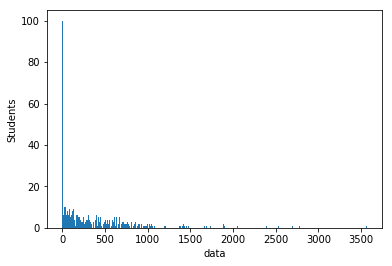

In [40]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).

passing_visits = []
nonpassing_visits = []

passing_visits, nonpassing_visits = sep_pass_nonpass(visits_by_account, passed_accounts)
passing_minutes, nonpassing_minutes = sep_pass_nonpass(total_minutes_by_account, passed_accounts)
passing_lessons, nonpassing_lessons = sep_pass_nonpass(total_lessons_by_account, passed_accounts)
#printresults(passing_visits)
#printresults(nonpassing_visits)
printresults(passing_minutes)
#printresults(nonpassing_minutes)
#printresults(passing_lessons)
#printresults(nonpassing_lessons)


    

## Making Histograms

In [28]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.



## Improving Plots and Sharing Findings

In [29]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.